# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [55]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
#     transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

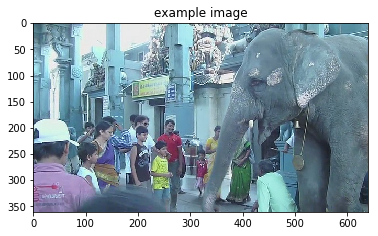

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [57]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [58]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=2)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (embed): Embedding(8855, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (linear): Linear(in_features=512, out_features=8855, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [59]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

print(features.shape)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 1, 512])
19.3811092376709
15.474939346313477
11.620159149169922
11.692121505737305
11.775700569152832
11.795909881591797
11.798382759094238
11.795333862304688
11.791763305664062
11.78923511505127
11.787823677062988
11.78730297088623
11.78741455078125
11.787939071655273
11.788703918457031
11.789597511291504
11.79053783416748
11.791476249694824
11.792376518249512
11.79322338104248
11.794007301330566
example output: [0, 0, 3, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [60]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ' '.join([data_loader.dataset.vocab.idx2word[idx] for idx in output])
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [61]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: <start> <start> a people people people people people people people people people people people people people people people people people people


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [47]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    
    return features

Run the code cell below (multiple times, if you like!) to test how this function works.

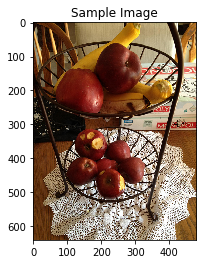

tensor([ 0.7331, -0.7164,  0.5672, -0.6925, -0.7158, -0.5375,  0.2679,
        -0.7545,  0.7532,  0.0674], device='cuda:0')
tensor([ 0.7217, -0.7285,  0.7718, -0.7671, -0.7576, -0.4627,  0.3040,
        -0.7646,  0.7289,  0.3710], device='cuda:0')
tensor([ 0.6924, -0.6965,  0.7912, -0.7757, -0.7595, -0.3023,  0.3432,
        -0.7676,  0.7258,  0.4564], device='cuda:0')
tensor([ 0.6877, -0.6819,  0.7920, -0.7773, -0.7597, -0.2482,  0.3548,
        -0.7680,  0.7232,  0.4801], device='cuda:0')
tensor([ 0.6868, -0.6781,  0.7916, -0.7779, -0.7597, -0.2350,  0.3573,
        -0.7680,  0.7207,  0.4884], device='cuda:0')
tensor([ 0.6867, -0.6765,  0.7914, -0.7781, -0.7597, -0.2322,  0.3580,
        -0.7680,  0.7196,  0.4916], device='cuda:0')
tensor([ 0.6866, -0.6759,  0.7913, -0.7782, -0.7597, -0.2321,  0.3582,
        -0.7680,  0.7192,  0.4928], device='cuda:0')
tensor([ 0.6865, -0.6757,  0.7913, -0.7783, -0.7597, -0.2325,  0.3583,
        -0.7680,  0.7190,  0.4933], device='cuda:0')
tensor([

In [48]:
f1 = get_prediction()

In [37]:
f1

tensor([[[ 0.1885,  0.9259, -1.3207,  1.2179, -0.6415, -0.2132, -2.2605,
           1.1011,  1.3637,  1.9070, -1.2249, -1.8133, -0.5251, -1.6842,
           3.0650, -0.7127, -0.7174,  1.9697,  0.0972,  1.5247, -2.0244,
          -0.5361, -0.7495,  0.7343, -1.5196,  0.0635, -0.5212,  1.1244,
          -0.2973, -0.2115, -0.0564, -0.1710, -0.6987,  0.5620,  0.1206,
           2.5483,  1.1802, -1.7444,  0.5858, -0.1255,  0.3057, -1.6017,
           0.8869,  0.3873, -0.7007,  0.5963, -1.6082,  1.7140,  0.3850,
           0.0380,  0.2867, -0.6662, -0.8459,  0.4588, -0.5164, -1.9827,
           0.2343, -2.5090, -1.7461, -1.6012, -1.0045,  0.3139,  0.8842,
          -0.7380,  3.2906, -1.8122,  0.3673,  0.8644, -0.3804,  1.1216,
           0.1497, -0.2474,  1.4798,  2.1107, -1.5586, -1.3081, -1.1907,
           1.0967, -0.8344,  0.5815, -0.1411,  1.3749,  0.2174, -0.7717,
           1.1438, -0.9407,  0.7683, -0.5587,  2.1336,  0.0547, -0.2363,
           0.8743,  1.3813,  0.5602,  1.6146,  0.19

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

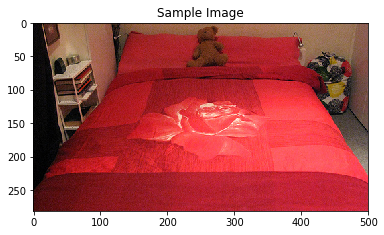

<start> <start> a a a a a a a a a a a a a a a a a a a


In [38]:
f2 = get_prediction()

In [39]:
f2

tensor([[[ 0.0836, -0.3239, -0.2036,  1.0596, -0.3305, -1.3625,  0.5087,
           0.8450,  0.4057,  2.7128, -0.9678,  0.0729, -0.9116, -0.8139,
           2.1874, -1.8005,  1.0649,  2.1450, -0.2187,  0.9918, -3.0310,
           1.0644, -1.8261, -1.3924, -2.0444,  1.0723, -0.3072, -0.4242,
          -2.5980,  0.2460, -0.4106, -2.0031, -0.8017, -1.0426, -0.5768,
           0.0577,  0.7415, -1.0288,  0.0389,  0.0526,  0.4165, -2.3770,
           2.8240, -1.7246, -0.7703,  0.1970,  0.2755,  0.6564, -0.9308,
          -0.0420,  0.5151,  0.2029, -1.2961,  0.3274,  0.5787,  0.0404,
           1.4050, -1.6724,  1.5821, -0.7246, -0.2931, -0.7196,  0.9015,
          -0.6810,  2.7500, -0.9729,  0.4504,  1.7172,  0.3331,  1.4508,
           1.5361, -0.5116,  1.4284,  0.6894, -0.0080, -2.0479,  0.6368,
           0.8654,  0.1813,  1.6682, -0.8770,  2.0817,  0.9642, -0.4908,
           0.8035,  0.9202,  0.1243,  0.5918,  1.7426,  1.3707,  0.2263,
           0.5752,  0.5049,  0.3724,  2.5470, -1.88

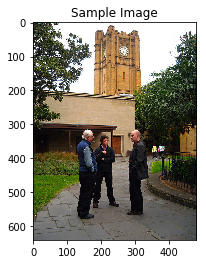

<start> <start> a a a a a a a a a a a a a a a a a a a


In [21]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

In [ ]:
get_prediction()

In [ ]:
get_prediction()